#### Imports and settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from random import randint
import re

from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
%load_ext jupyternotify

c:\users\andrz\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<IPython.core.display.Javascript object>

#### Customize IDE

In [2]:
# IDE theme
!jt -t chesterish -f roboto -fs 9 -nfs 11

In [3]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

#### Load datasets and pretrained models

In [4]:
PATH = '../input/'
GLOVE_FILE = f'{PATH}glove.6B.50d.txt'
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')

### EDA (Exploratory data analysis)

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [10]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [11]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

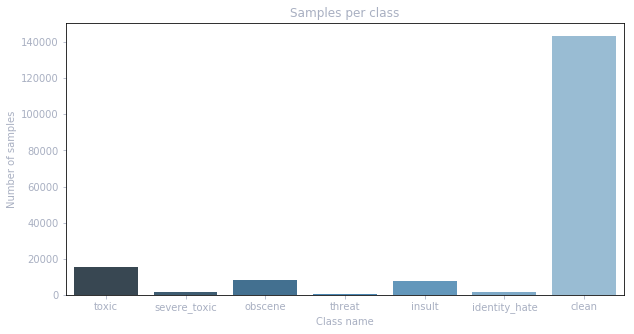

In [12]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

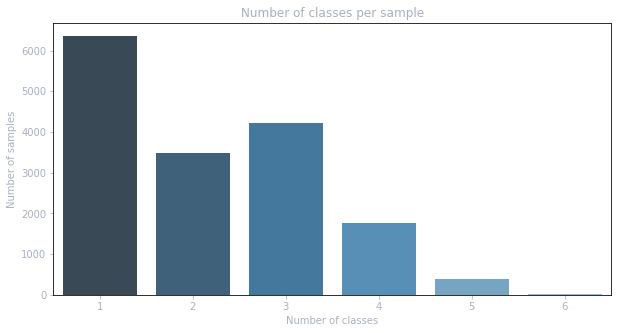

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [13]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [14]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [15]:
comments_labels_train.sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [16]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

In [17]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> "

{{unblock|DISCLAIMER: I do not identify as a Nazi, Neo-Nazi, Facist, Neo-Fascist. I do not accept or agree with the actions or views of Hitler or any other dictators in the world for that matter. I do not hate Jews... in fact I have many jewish friends...
Hello, although this is technically an unblock appeal, it is really only a reason to explain.... you won't be in a mood to unblock me when I'm finished talking... )
First of all I want to apologise, I should have thought before putting the giant swastika on my page. This is the reason for that... I have a few Jewish friends, and normally we sometimes make jokes about jews and christians and things like that. I never really make jokes about the holocaust, because that never go over well with them and it is not nice... well, apparently, a joke about jews being lawyers set one of my closest friends off who is not really a jew, but claims he is.... now he thinks I am a facist, nazi, and I hate jews.... i gotreally frustrated 

#### Wordclouds

In [18]:
stopwords=set(STOPWORDS)

wordcloud_toxic = WordCloud(max_words=1000, stopwords=stopwords, colormap="Reds")
wordcloud_toxic.generate(" ".join(toxic_samples.comment_text.values))

wordcloud_clean = WordCloud(max_words=1000, stopwords=stopwords, colormap="Greens")
wordcloud_clean.generate(" ".join(clean_samples.comment_text.values))

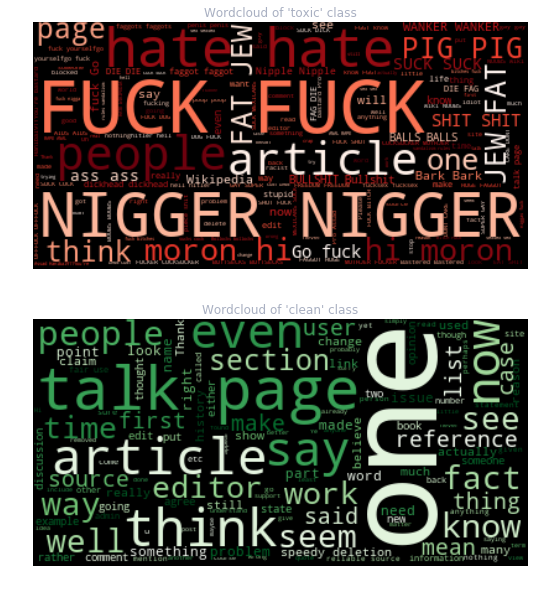

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Wordcloud of \'toxic\' class")
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")

plt.subplot(212)
plt.axis("off")
plt.title("Wordcloud of \'clean\' class")
plt.imshow(wordcloud_clean, interpolation='bilinear')

plt.show()

#### Spam significance 

In [20]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

In [21]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('Clean spammers: ', n_clean_spammers, "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', n_toxic_spammers, "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers) ,'times more toxic spammers than clean ones!')

Clean spammers:  67 ( 19 % )
Toxic spammers:  292 ( 81 % )

There are 4.36 times more toxic spammers than clean ones!


In [22]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1
print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> "

""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - you gotta go sometime.""
""See no reason for it - 

### Prepare data for model training

#####  Comments tokenizing

In [23]:
classes_names = train.columns.values[2:]
labels_train = train[classes_names].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

In [24]:
num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [25]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

In [26]:
tokenized_sequences_train = tokenizer.texts_to_sequences(comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

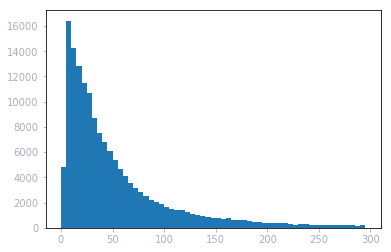

In [27]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

##### Vector padding

In [28]:
maxlen = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('\nAfter padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]

After padding: ( 180 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  3

### Building the model

In [ ]:
# Initialize all params used in both solutions of bulding the model
# Commented params are tuned by Grid Search
embedding_output_dim = 64
lstm_units = 100
# dropout_rate = 0.2 
dense_units = 50
n_classes = len(classes_names)

In [ ]:
# Params for model training
batch_size = 64
epochs = 2

##### First version of model; Grid Search is not possible to execute with this solution
<font color="LIGHTSALMON">All cells from section below made raw ('R'); to enable them again, press 'Y' on each of them</font>

##### Tuning params with Grid Search

In [45]:
def create_model(dropout_rate=0.1):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=embedding_output_dim))
    model.add(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=0.2))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [46]:
model = KerasClassifier(build_fn=create_model, epochs=2, batch_size=64, verbose=1)

dropout_rate = [0.2, 0.5, 0.8]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

### Model training

In [ ]:
X_train = fixed_sequences_train
y_train = labels_train

##### <font color="LIGHTSALMON">Classic training - not used, made raw ('R'); to enable them again, press 'Y'</font>

##### Training with Grid Search

In [ ]:
grid_result = grid.fit(X_train, y_train)
print("Best score: %f with params: %s" % (grid_result.best_score_, grid_result.best_params_))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2
106380/106380 [==============================] - 445s 4ms/step - loss: 0.1006 - acc: 0.9702
Epoch 2/2
106380/106380 [==============================] - 108s 1ms/step
Epoch 1/2
106381/106381 [==============================] - 452s 4ms/step - loss: 0.0938 - acc: 0.9719
Epoch 2/2
106381/106381 [==============================] - 126s 1ms/step
Epoch 1/2
106381/106381 [==============================] - 500s 5ms/step - loss: 0.0999 - acc: 0.9710
Epoch 2/2
106381/106381 [==============================] - 99s 927us/step
Epoch 1/2
106380/106380 [==============================] - 430s 4ms/step - loss: 0.1115 - acc: 0.9688
Epoch 2/2
106380/106380 [==============================] - 120s 1ms/step
Epoch 1/2
 98432/106381 [==========================>...] - ETA: 38s - loss: 0.1102 - acc: 0.9686

##### Predicting on test dataset and create submission file

In [43]:
X_test = fixed_sequences_test
y_test = model.predict([X_test], batch_size=1024)

In [45]:
sample_submission = pd.read_csv(f'{PATH}sample_submission.csv')
sample_submission[classes_names] = y_test
sample_submission.to_csv('submission.csv', index=False)

##### Manual model testing

In [46]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

In [49]:
single_comment = 'FUCK THIS BITCH!'
single_prediction = model.predict([prepare_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)


Deteced class:  toxic 
Score:  99.82206225395203  %

 ¯\_(ツ)_/¯

All results:
       toxic severe_toxic   obscene    threat    insult identity_hate
0  0.998221     0.364022  0.991724  0.019551  0.763101      0.105575
